<a href="https://colab.research.google.com/github/pam-lab/JupyterFiles/blob/main/Similarity_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!nvidia-smi

Wed Jun  8 15:03:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    38W / 250W |   1521MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data Loading and processing

In [8]:
!git clone https://github.com/language-ml/course-nlp-ir-1-text-exploring

fatal: destination path 'course-nlp-ir-1-text-exploring' already exists and is not an empty directory.


In [9]:
import random 
import nltk
import pandas as pd
import codecs
import tqdm

quranic_dir = "/content/course-nlp-ir-1-text-exploring/exploring-datasets/religious_text"
df_quran = pd.read_csv(f'{quranic_dir}/quranic_data/id_text_with_orthographies.txt', sep='\t', header=None)
df_nahj = pd.read_csv(f'{quranic_dir}/nahj-al-balaqa/Nahj Al-Balaqa.txt', sep='\t',header=None)
verse_complete_dict = pd.Series(df_quran[1].tolist(), index=df_quran[0]).to_dict()
nahj_complete_dict = pd.Series(df_nahj[1].tolist(), index=df_nahj[0]).to_dict()

In [10]:
from pathlib import Path
import re
sahife_text=Path(f'{quranic_dir}/Saheefa/sahife_sajjadieh.txt').read_text().split('\n')
sahife_complete_dict = [re.sub('[(][۰-۹]+[)]','', item) for item in sahife_text if item.startswith('(')]

In [11]:
sahife_complete_dict[12]

' حَمْداً یَرْتَفِعُ مِنَّا إِلَی أَعْلَی عِلِّیِّینَ فِي کِتَابٍ مَرْقُومٍ یَشْهَدُه\u200cُ الْمُقَرَّبُونَ. '

In [12]:
nahj_complete_dict['2##186']

'وَ قَالَ ع لِلظّالِمِ الباَدیِ غَداً بِکَفّهِ عَضّةٌ'

In [13]:
verse_complete_dict['2##186']

'وَإِذَا سَأَلَكَ عِبَادِي عَنِّي فَإِنِّي قَرِيبٌ ۖ أُجِيبُ دَعْوَةَ الدَّاعِ إِذَا دَعَانِ ۖ فَلْيَسْتَجِيبُوا لِي وَلْيُؤْمِنُوا بِي لَعَلَّهُمْ يَرْشُدُونَ'

### Normalize

In [14]:
pip install -Uq camel_tools

In [15]:
from camel_tools.utils.normalize import normalize_unicode
from camel_tools.utils.normalize import normalize_alef_maksura_ar
from camel_tools.utils.normalize import normalize_alef_ar

from camel_tools.utils.normalize import normalize_alef_bw
from camel_tools.utils.normalize import normalize_alef_hsb

from camel_tools.utils.normalize import normalize_teh_marbuta_ar
from camel_tools.utils.dediac import dediac_ar

def normalize_arabic(sentence):

    # Normalize alef variants to 'ا'
    sent_norm = normalize_unicode(sentence)
    
    sent_norm = normalize_alef_bw(sent_norm)
    # Normalize alef variants to 'ا'
    sent_norm = normalize_alef_ar(sentence)

    # Normalize alef maksura 'ى' to yeh 'ي'
    sent_norm = normalize_alef_maksura_ar(sent_norm)

    # Normalize teh marbuta 'ة' to heh 'ه'
    sent_norm = normalize_teh_marbuta_ar(sent_norm)
    return dediac_ar(sent_norm)

In [16]:
from camel_tools.utils import normalize


verse_complete_dict_nrmlz = {k:normalize_arabic(v) for k,v in tqdm.tqdm(verse_complete_dict.items())}
nahj_complete_dict_nrmlz = {k:normalize_arabic(v) for k,v in tqdm.tqdm(nahj_complete_dict.items())}
sahife_complete_dict_nrmlz = [normalize_arabic(item) for item in tqdm.tqdm(sahife_complete_dict)]

100%|██████████| 924/924 [00:00<00:00, 9317.49it/s]


In [17]:
print(verse_complete_dict['2##186'])
print(verse_complete_dict_nrmlz['2##186'])

print(nahj_complete_dict['2##186'])
print(nahj_complete_dict_nrmlz['2##186'])

print(sahife_complete_dict[34])
print(sahife_complete_dict_nrmlz[34])

وَإِذَا سَأَلَكَ عِبَادِي عَنِّي فَإِنِّي قَرِيبٌ ۖ أُجِيبُ دَعْوَةَ الدَّاعِ إِذَا دَعَانِ ۖ فَلْيَسْتَجِيبُوا لِي وَلْيُؤْمِنُوا بِي لَعَلَّهُمْ يَرْشُدُونَ
واذا سالك عبادي عني فاني قريب ۖ اجيب دعوه الداع اذا دعان ۖ فليستجيبوا لي وليؤمنوا بي لعلهم يرشدون
وَ قَالَ ع لِلظّالِمِ الباَدیِ غَداً بِکَفّهِ عَضّةٌ
و قال ع للظالم البادی غدا بکفه عضه
 وَ کَاشَفَ فِي الدُّعَاءِ إِلَیْکَ حَامَّتَه‌ُ 
 و کاشف في الدعاء الیک حامته‌ 


In [18]:
quranic_tokenized = [sents.split() for sents in tqdm.tqdm(verse_complete_dict_nrmlz.values())]
nahj_tokenized = [sents.split() for sents in tqdm.tqdm(nahj_complete_dict_nrmlz.values())]
sahife_tokenized = [sents.split() for sents in tqdm.tqdm(sahife_complete_dict_nrmlz)]

100%|██████████| 924/924 [00:00<00:00, 238773.76it/s]


(array([224., 255., 200., 122.,  69.,  32.,  16.,   3.,   2.,   1.]),
 array([  3. ,  13.7,  24.4,  35.1,  45.8,  56.5,  67.2,  77.9,  88.6,
         99.3, 110. ]),
 <a list of 10 Patch objects>)

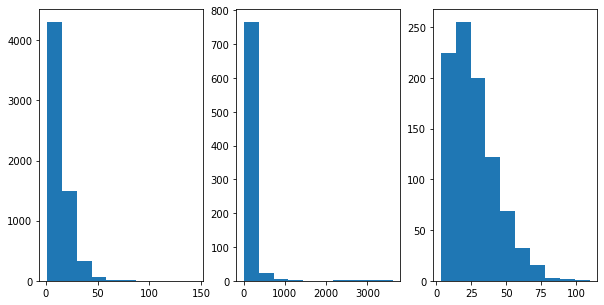

In [19]:
import matplotlib.pyplot as plt
size_quran_token = [len(sentence) for sentence in quranic_tokenized]
size_nahj_token =[len(sentence) for sentence in nahj_tokenized]
size_sahife_token = [len(sentence) for sentence in sahife_tokenized]
fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(10,5))
axes[0].hist(size_quran_token)
axes[1].hist(size_nahj_token)
axes[2].hist(size_sahife_token)

# Common Modules

In [20]:
pip install transformers -Uqq

In [21]:
def tokenize(sentence_list):
    return tokenizer.batch_encode_plus(sentence_list,
                    add_special_tokens=True,
                    max_length=128,
                    padding='max_length',
                    return_attention_mask=True,
                    truncation=True,
                    return_tensors='pt')

# Similarity without finetuning

## Loading Bert Model

In [22]:
from transformers import AutoTokenizer, AutoModel
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Mini:   asafaya/bert-mini-arabic
# Medium: asafaya/bert-medium-arabic
# Base:   asafaya/bert-base-arabic
# Large:  asafaya/bert-large-arabic
# https://www.youtube.com/watch?v=jVPd7lEvjtg

tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
model = AutoModel.from_pretrained("asafaya/bert-base-arabic")

model=model.to(device)

model.eval()

Some weights of the model checkpoint at asafaya/bert-base-arabic were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(32000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

## Extract Embedding Vectors

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader,TensorDataset

batch_values = list(verse_complete_dict_nrmlz.values())
encoding= tokenize(batch_values)

dataset=TensorDataset(encoding.input_ids, encoding.attention_mask)
dataloader = DataLoader(dataset,batch_size=128,drop_last=False,shuffle=False)

predictions = []
with torch.no_grad():
    for (input_ids, attention_mask) in dataloader:
        prediction = model(input_ids.to(device),attention_mask.to(device))
        predictions.append(prediction.last_hidden_state)

predictions = torch.cat(predictions,dim=0)

## Compute Similarity Score

In [ ]:
attention_mask=encoding.attention_mask.unsqueeze(-1).expand(predictions.shape).float()
# for filtering out unnecessary ones
mask_embeddings=predictions.cpu() * attention_mask

summed = torch.sum(mask_embeddings,dim=1)
count = torch.clamp(attention_mask.sum(dim=1),min=1e-9)
mean_embedding = summed / count
mean_embedding.shape

from sklearn.metrics.pairwise import cosine_similarity

COMPARE_FROM = 20
mean_embedding = mean_embedding.numpy()
similarity=cosine_similarity(
    [mean_embedding[COMPARE_FROM]],
    mean_embedding 
).squeeze()

most_similar=similarity.argsort()[-10:][::-1]
verse_complete=pd.DataFrame(verse_complete_dict_nrmlz.values())
print(verse_complete.iloc[COMPARE_FROM].values)
pd.set_option('display.max_colwidth', None)

verse_complete.iloc[most_similar]

# Similarity with fine-tunning

In [4]:
pip install transformers -Uqq

In [5]:
from transformers import BertTokenizer, BertForMaskedLM
import torch
from transformers import AdamW
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Mini:   asafaya/bert-mini-arabic
# Medium: asafaya/bert-medium-arabic
# Base:   asafaya/bert-base-arabic
# Large:  asafaya/bert-large-arabic

tokenizer = BertTokenizer.from_pretrained("asafaya/bert-base-arabic")
model = BertForMaskedLM.from_pretrained("asafaya/bert-base-arabic")

model=model.to(device)
model.train()

optim = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [6]:
raw_data = list(verse_complete_dict_nrmlz.values())
raw_data= raw_data+list(nahj_complete_dict_nrmlz.values())
raw_data= raw_data +list(sahife_complete_dict_nrmlz)
inputs=tokenize(raw_data)
inputs['labels'] = inputs.input_ids.detach().clone()

NameError: ignored

In [21]:
rand = torch.rand(inputs.input_ids.shape)
mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * \
           (inputs.input_ids != 102) * (inputs.input_ids != 0)
mask_arr

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False]])

In [22]:
selection = []

for i in range(inputs.input_ids.shape[0]):
    selection.append(
        torch.flatten(mask_arr[i].nonzero()).tolist()
    )

for i in range(inputs.input_ids.shape[0]):
    inputs.input_ids[i, selection[i]] = 103 #masked_tokens

In [58]:
from tqdm import tqdm  # for our progress bar


from torch.utils.data import TensorDataset, DataLoader
dataset=TensorDataset(inputs.input_ids, inputs.attention_mask,inputs.labels)
dataloader = DataLoader(dataset,batch_size=64,drop_last=False,shuffle=True)


epochs = 2

for epoch in range(epochs):
    loop = tqdm(dataloader, leave=True)
    for batch in loop:
        optim.zero_grad()

        input_ids, attention_mask,labels = batch
        outputs = model(input_ids.to(device), attention_mask=attention_mask.to(device),
                        labels=labels.to(device))
        loss = outputs.loss
        loss.backward()
        optim.step()
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

Epoch 1: 100%|██████████| 125/125 [01:47<00:00,  1.16it/s, loss=0.0885]


In [65]:
model.save_pretrained("model-trained-on-arabic")


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
model = AutoModel.from_pretrained("model-trained-on-arabic")
model=model.to(device)
model.eval()

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader,TensorDataset

def get_mean_embedding(model,sentences):
    encoding= tokenize(sentences)

    dataset=TensorDataset(encoding.input_ids, encoding.attention_mask)
    dataloader = DataLoader(dataset,batch_size=128,drop_last=False,shuffle=False)

    predictions = []
    with torch.no_grad():
        for (input_ids, attention_mask) in dataloader:
            prediction = model(input_ids.to(device),attention_mask.to(device))
            predictions.append(prediction.last_hidden_state)

    predictions = torch.cat(predictions,dim=0)

    attention_mask=encoding.attention_mask.unsqueeze(-1).expand(predictions.shape).float()
    # for filtering out unnecessary ones
    mask_embeddings=predictions.cpu() * attention_mask

    summed = torch.sum(mask_embeddings,dim=1)
    count = torch.clamp(attention_mask.sum(dim=1),min=1e-9)
    mean_embedding = summed / count

    return mean_embedding

In [3]:
mean_embedding = get_mean_embedding(model,list(verse_complete_dict_nrmlz.values()))

NameError: ignored

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

COMPARE_FROM = 10
mean_embedding = mean_embedding.numpy()
similarity=cosine_similarity(
    [mean_embedding[COMPARE_FROM]],
    mean_embedding 
).squeeze()

most_similar=similarity.argsort()[-10:][::-1]
verse_complete=pd.DataFrame(verse_complete_dict_nrmlz.values())
print(verse_complete.iloc[COMPARE_FROM].values)
pd.set_option('display.max_colwidth', None)

verse_complete.iloc[most_similar]